In [1]:
import os

import numpy as np
import pandas as pd
from astropy.io import fits
import importlib

import statmorph
from statmorph.utils.image_diagnostics import make_figure
from utils.data import segmentation_map, circular_mask, zoom_in, create_morph_df
from utils.plots import plot_light, display_img
%matplotlib inline

In [2]:
data_dir = 'cluster_data/'
drz_file = os.path.join(data_dir, 'hlsp_clash_hst_acs-wfc3ir_a383_total_v1_drz.fits')
whz_file = os.path.join(data_dir, 'hlsp_clash_hst_acs-wfc3ir_a383_total_v1_whz.fits')
hdulist = fits.open(drz_file)
drz = hdulist[0].data

In [3]:
full_segmap = segmentation_map(drz, nsigma=10.)

In [4]:
full_source_morphs = statmorph.source_morphology(image=drz,
                                                 segmap=full_segmap,
                                                 gain=2.25)

/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/statmorph/statmorph.py:691: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)
/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/statmorph/statmorph.py:691: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)


In [6]:
def func(src):
    return src.r50      # sort on half-light radius to get BCG

full_source_morphs.sort(reverse=True, key=func)
bcg = full_source_morphs[1]
full_morph_df = create_morph_df(full_source_morphs)

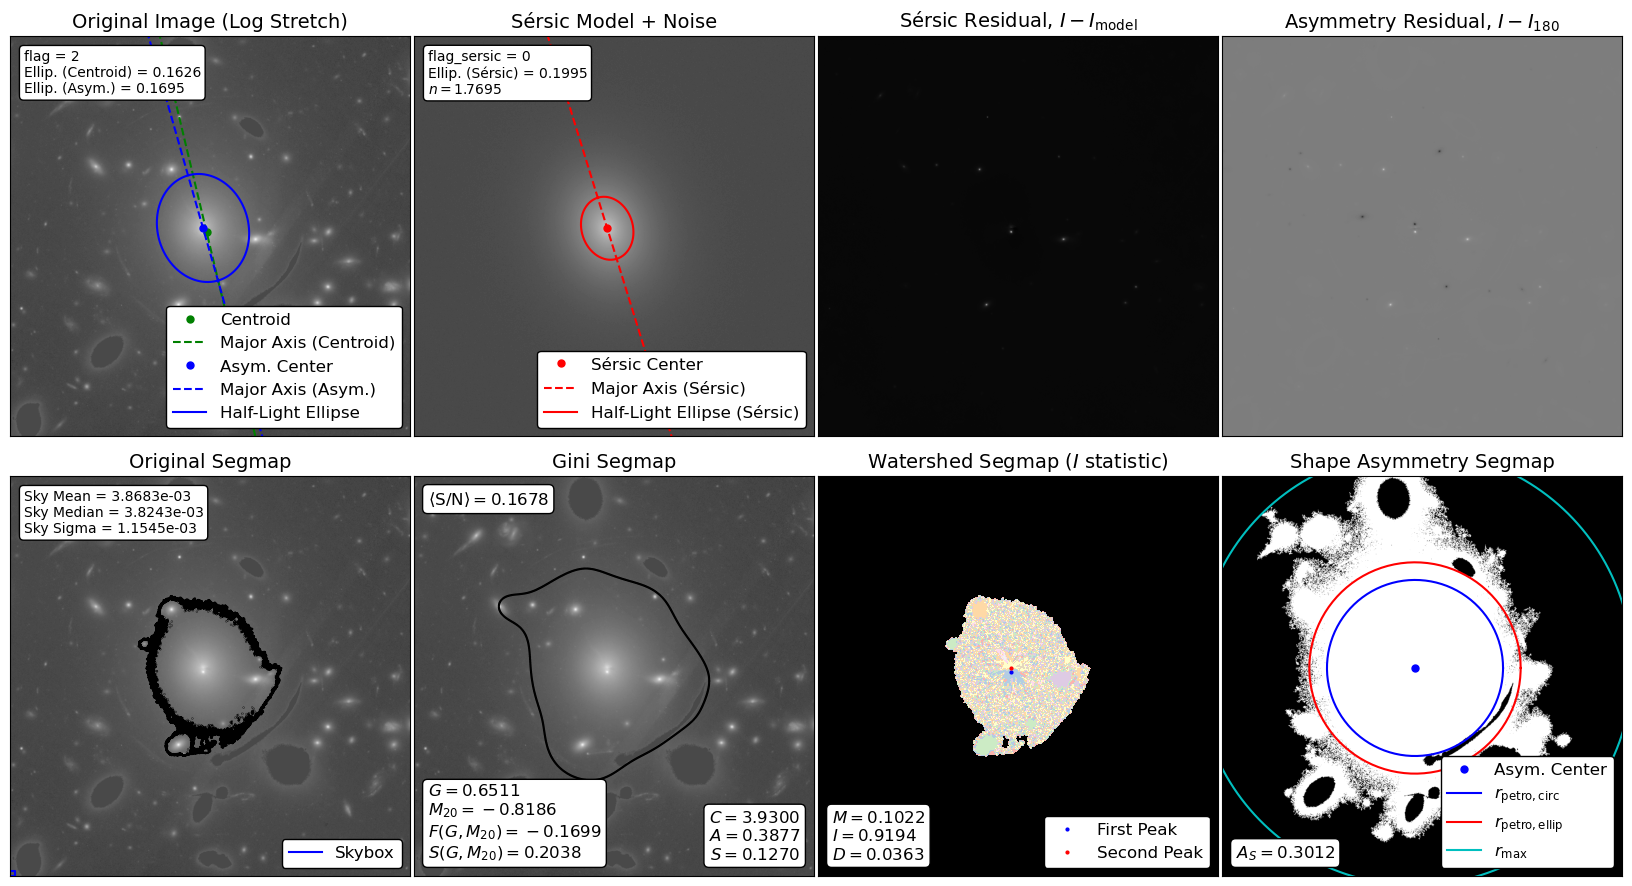

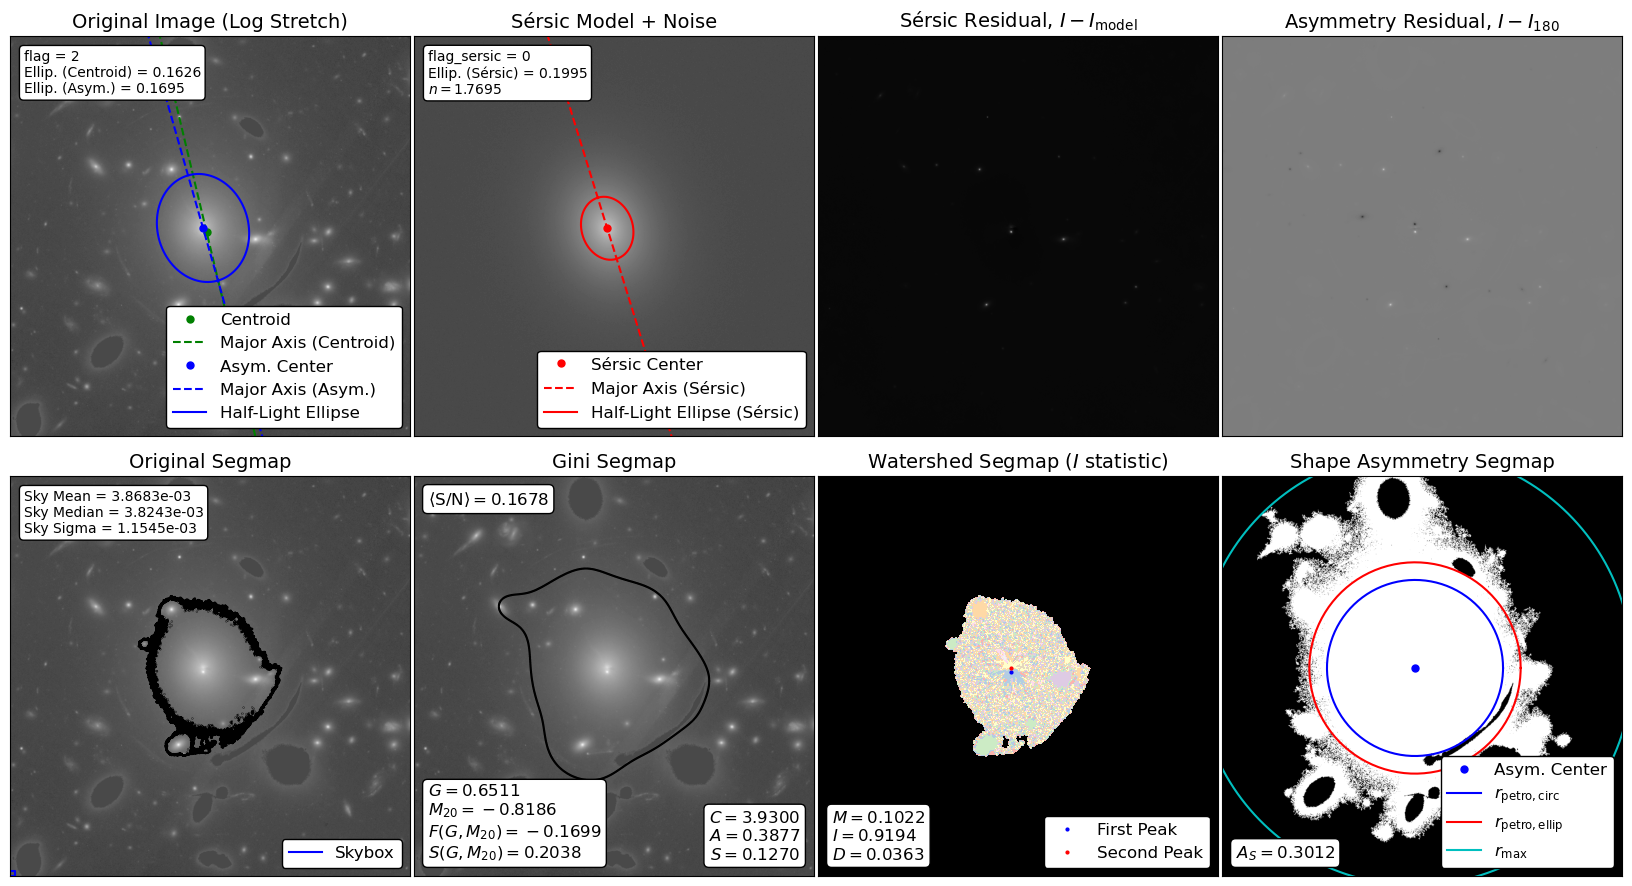

In [7]:
make_figure(bcg)

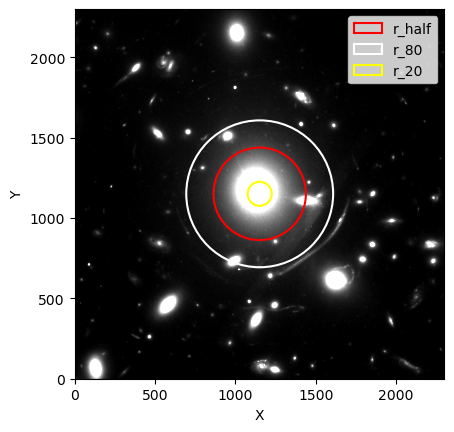

In [8]:
zoomed_region, zoom_size = zoom_in(bcg, drz)
plot_light(bcg, zoomed_region, zoom_size)

In [9]:
center = (bcg.xc_centroid, bcg.yc_centroid)
rads = bcg.r50*np.linspace(1, 5, num=10)
morphs_list = []
for radius in rads:
    mask = circular_mask(drz, center, radius)
    # display_img(image=drz, mask=mask)
    sm_mask = mask.astype(int)
    morph = statmorph.source_morphology(drz,
                                     segmap=sm_mask,
                                     gain=2.25)
    morphs_list.append(morph[0])

In [10]:
morphs_list

In [20]:
def create_df(source_morphs, name=None, save=False):

    sources = []
    for src in source_morphs:
        sources.append({
            'xc_centroid': src.xc_centroid,
            'yc_centroid': src.yc_centroid,
            'ellipticity_centroid': src.ellipticity_centroid,
            'elongation_centroid': src.elongation_centroid,
            'orientation_centroid': src.orientation_centroid,
            'xc_asymmetry': src.xc_asymmetry,
            'yc_asymmetry': src.yc_asymmetry,
            'ellipticity_asymmetry': src.ellipticity_asymmetry,
            'elongation_asymmetry': src.elongation_asymmetry,
            'orientation_asymmetry': src.orientation_asymmetry,
            'rpetro_circ': src.rpetro_circ,
            'rpetro_ellip': src.rpetro_ellip,
            'rhalf_circ': src.rhalf_circ,
            'rhalf_ellip': src.rhalf_ellip,
            'r20': src.r20,
            'r50': src.r50,
            'r80': src.r80,
            'Gini': src.gini,
            'M20': src.m20,
            'F(G, M20)': src.gini_m20_bulge,
            'S(G, M20)': src.gini_m20_merger,
            'sn_per_pixel': src.sn_per_pixel,
            'C': src.concentration,
            'A': src.asymmetry,
            'S': src.smoothness,
            'sersic_amplitude': src.sersic_amplitude,
            'sersic_rhalf': src.sersic_rhalf,
            'sersic_n': src.sersic_n,
            'sersic_xc': src.sersic_xc,
            'sersic_yc': src.sersic_yc,
            'sersic_ellip': src.sersic_ellip,
            'sersic_theta': src.sersic_theta,
            'sersic_chi2_dof': src.sersic_chi2_dof,
            'sky_mean': src.sky_mean,
            'sky_median': src.sky_median,
            'sky_sigma': src.sky_sigma,
            'flag': src.flag,
            'flag_sersic': src.flag_sersic,
        })

    sources = pd.DataFrame(sources)
    if save:
        if name is not None:
            sources.to_csv(name)
        else:
            sources.to_csv('source_morphs.csv')
    return sources

In [21]:
morph_df = create_df(morphs_list, save=True)

In [23]:
morph_df.insert(0, 'Radius (px)', rads)

In [25]:
morph_df.to_csv('source_morphs.csv')

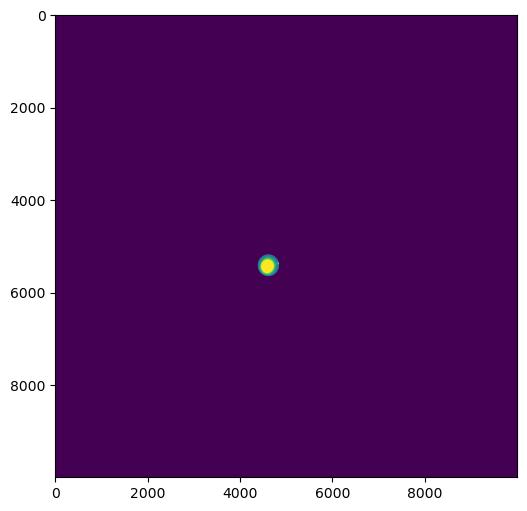

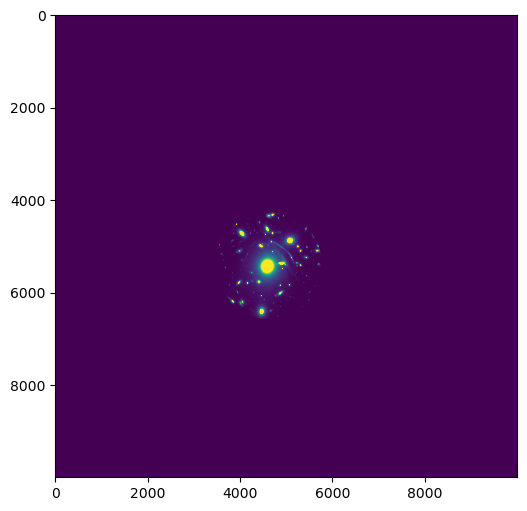

In [26]:
mask = circular_mask(drz, center, rads[0])
display_img(image=drz, mask=mask)

mask = circular_mask(drz, center, rads[9])
display_img(image=drz, mask=mask)

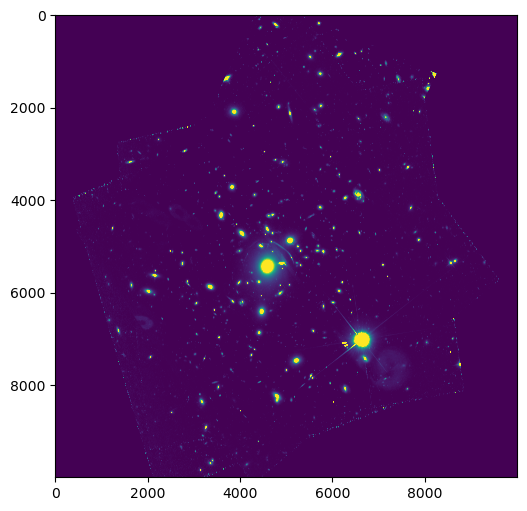

In [27]:
display_img(drz)